<a href="https://colab.research.google.com/github/benbatman/CNN_Projects/blob/main/PyTorch_Paper_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will be replicating **ViT** : Vision Transformer

Linke to paper: https://arxiv.org/abs/2010.11929

In [ ]:
import torch 
import torchvision 
assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Torch version: 1.13.0+cu116
Torchvision version: 0.14.0+cu116


In [ ]:
import matplotlib.pyplot as plt 
import torch 
import torchvision  

from torch import nn 
from torchvision import transforms    

try: 
  from torchinfo import summary  
except: 
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary 



[INFO] Couldn't find torchinfo... installing it.


Saving going_modular.zip to going_modular.zip
Archive:  going_modular.zip
   creating: going_modular/__pycache__/
  inflating: going_modular/__pycache__/data_setup.cpython-39.pyc  
  inflating: going_modular/__pycache__/engine.cpython-39.pyc  
  inflating: going_modular/__pycache__/model_builder.cpython-39.pyc  
  inflating: going_modular/__pycache__/utils.cpython-39.pyc  
  inflating: going_modular/data_setup.py  
  inflating: going_modular/engine.py  
  inflating: going_modular/get_data.py  
  inflating: going_modular/model_builder.py  
  inflating: going_modular/train.py  
  inflating: going_modular/utils.py  


In [ ]:
from going_modular import data_setup, engine

In [ ]:
# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3297, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 3297 (delta 139), reused 230 (delta 111), pack-reused 3020
Receiving objects: 100% (3297/3297), 642.45 MiB | 15.78 MiB/s, done.
Resolving deltas: 100% (1869/1869), done.
Checking out files: 100% (221/221), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cuda'

## Get Data 

In [ ]:
# Download pizza, steak, sushi images from GitHub 
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", 
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Set up directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create Datasets and DataLoaders

### Prepare transforms for images

In [ ]:
# Create image size (from table 3 in the ViT paper)
IMG_SIZE = 224 

# Create transform pipeline manually 
manual_transforms = transforms.Compose([ 
    transforms.Resize((IMG_SIZE, IMG_SIZE)), 
    transforms.ToTensor()
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


### Turn images into `DataLoader's`  

In [ ]:
# Set the batch size 
BATCH_SIZE = 32 # Lower than ViT paper but they had more compute power 

# Create dataloaders 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, 
    test_dir=test_dir, 
    transform=manual_transforms, # use our manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f392c167280>,
 ['pizza', 'steak', 'sushi'])

### Visualize a single image

In [ ]:
# Get a batch of images 
image_batch, label_batch = next(iter(train_dataloader)) 

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes 
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

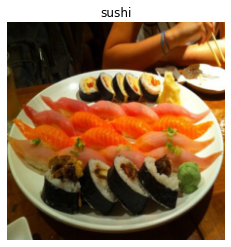

In [ ]:
# Plot the image with matplotlib 
plt.imshow(image.permute(1,2,0)) # Rearragne dims to suit matplotlib 
plt.title(class_names[label])
plt.axis(False);

## Replicating the ViT paper: an overview

### Inputs and outputs, layers and blocks

- **Layer** - takes an input, performs a function on it, returns an output 
- **Block** - a collection of layers, takes an input, performs a series of functions on it, returns an output 
- **Architecture (or model)** a collection of blocks, takes an input, performs a series of functions on it, returns an output




### Getting specific: What's ViT made of?

**Model overview:** We split an image into fixed-size patches, linearly embed each of them,
add position embeddings, and feed the resulting sequence of vectors to a standard Transformer
encoder. In order to perform classification, we use the standard approach of adding an extra learnable
“classification token” to the sequence

- **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block
- **Hidden size (D)** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
**MLP Size** - What are the number of hidden units in the MLP layers?
**Heads** - How many heads are there in the MSA layers
**Params** -  What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

## Euqation 1: Split data into patches and creating the class, positions and patch embedding

It's all about the embedding

Start with the **patch embedding** 
Turn our image into a sequence of patches and then embed those patches 

### Calculating patch embedding input and output shapes by hand


In [ ]:
# Create example values 
height = 224 # H 
width = 224 # W 
color_channels = 3 # C 
patch_size = 16 # P 

# Calculate N (number of patches) 
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [ ]:
# Input shape (this is the size of a single image) 
embedding_layer_input_shape = (height, width, color_channels) 

# Output shape 
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels) 

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### Turning a single image into patches 

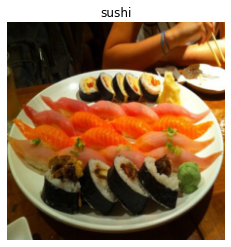

In [ ]:
# View single image 
plt.imshow(image.permute(1,2,0)) # adjust for matplotlib 
plt.title(class_names[label]) 
plt.axis(False);

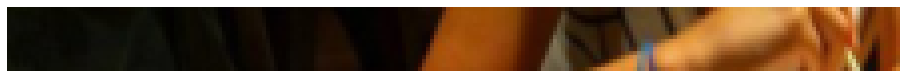

In [ ]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) 
image_permuted = image.permute(1,2,0) 

# Index to plot the top row of patched pixels 
patch_size = 16 
plt.figure(figsize=(patch_size, patch_size)) 
plt.imshow(image_permuted[:patch_size, :, :])
plt.axis(False);

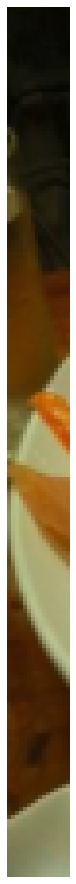

In [ ]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) 
image_permuted = image.permute(1,2,0) 

# Index to plot the top row of patched pixels 
patch_size = 16 
plt.figure(figsize=(patch_size, patch_size)) 
plt.imshow(image_permuted[:, :patch_size, :])
plt.axis(False);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


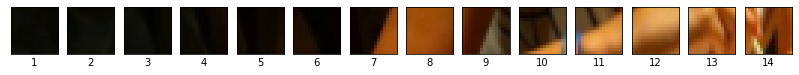

In [ ]:
# Set up hyperparameters and make sure img_size and patch_size are compatible 
img_size = 224 
patch_size = 16 
num_patches = img_size/patch_size # should end up with 14 individual patches
assert img_size % patch_size == 0, "Image size must be divisable by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots 
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches), 
                        sharex=True, 
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)): 
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1) # set the label 
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0      
Number of patches per column: 14.0      
Total patches: 196.0      
Patch size: 16 pixels x 16 pixels


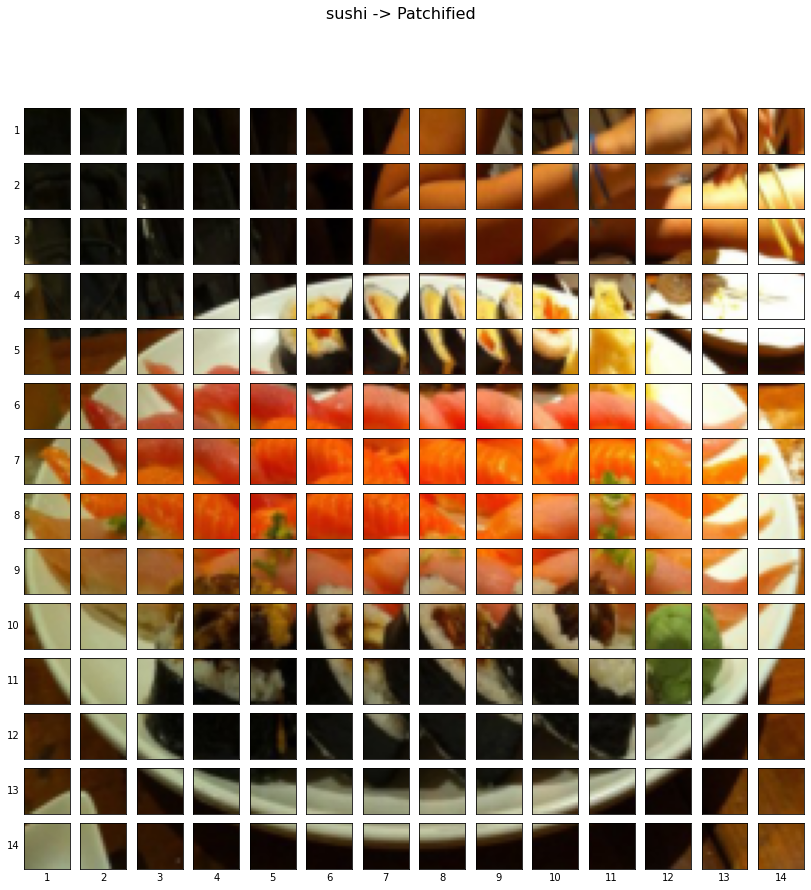

In [ ]:
# Set up hyperparameters
img_size = 224 
patch_size = 16 
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {num_patches}\
      \nNumber of patches per column: {num_patches}\
      \nTotal patches: {num_patches*num_patches}\
      \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots 
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches), 
                        sharex=True, 
                        sharey=True)

# Loop through height and width of image 
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate though

    # Plot the permuted image patch (image_permtuted -> (Height, Width, CC
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                     patch_width:patch_width+patch_size, # iterate through width 
                      :]) # get all color channels

    # set up label information, remove the ticks for clarity and set labels to outside
    axs[i, j].set_ylabel(i+1, 
                         rotation='horizontal', 
                         horizontalalignment='right', 
                         verticalalignment='center')
    
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([]) 
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set a super title 
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16) 
plt.show()

### Creating image patches with `torch.nn.Conv2d()`


In [ ]:
from torch import nn 

# Set the patch size 
patch_size = 16 

# Create the Conv2d layer with hyperparameter from the ViT paper 
conv2d = nn.Conv2d(in_channels=3, # number of color channels 
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding 
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size, 
                   padding=0)

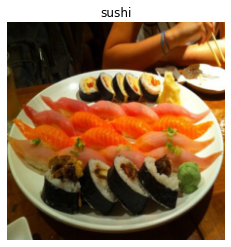

In [ ]:
# View single image 
plt.imshow(image.permute(1,2,0)) # adjust for matplotlib 
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, CC) -> (batch, height, width, CC)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Passing our image through the convolutional layer turns it into a series of 768 (this is the embedding size or D) feature/activation maps.

**shape:** [batch_size, embedding_dim, feature_map_height, feature_map_width]

Showing random convolutional feature maps from indexes: [717, 15, 6, 258, 398]


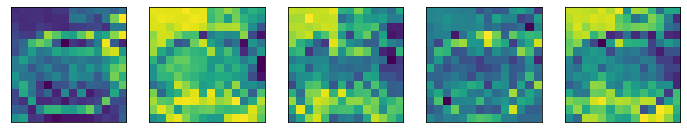

In [ ]:
# Plot random 5 convolutional feature maps 
import random 
random_indexes = random.sample(range(0,768), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot 
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

# Plot random image feature maps 
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

The important thing to note is that these features may change over time as the neural network learns.

And because of these, these feature maps can be considered a **learnable embedding** of our image.

In [ ]:
# Get a single feature map in tensor form 
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 1.3712e-02,  3.9568e-02,  7.3173e-03,  3.3732e-03,  1.9861e-02,
            2.7892e-02,  8.9895e-02,  1.0528e-01,  1.6786e-01,  2.2051e-01,
            2.7171e-01,  1.7370e-03,  4.9030e-02,  7.0818e-03],
          [-6.6329e-03,  5.0690e-03, -1.3761e-02,  1.1716e-02,  1.3738e-02,
            1.2729e-02,  1.4620e-01,  1.4305e-01,  2.2224e-01, -8.7830e-02,
            1.8609e-02,  3.9825e-01,  5.6251e-01,  7.3707e-01],
          [ 1.1870e-02,  1.0318e-03, -2.6411e-02,  4.7596e-02,  8.9534e-03,
           -1.7587e-04,  2.6137e-02, -3.3840e-02, -1.1964e-02, -3.6598e-02,
            1.0236e-02, -3.3974e-02,  3.3521e-01,  1.1545e-01],
          [ 2.1623e-02,  3.5441e-02,  9.5761e-03,  3.3317e-01,  5.2049e-01,
            5.6837e-01,  3.1186e-01,  3.3753e-01,  4.8898e-01,  7.3532e-01,
            4.3587e-01,  4.0601e-01,  5.6831e-01,  4.0085e-01],
          [ 5.0084e-02,  2.1657e-01,  4.4557e-01,  3.1556e-01, -3.4371e-02,
           -5.4560e-02,  6.2431e-02, -7.2253e-02, -2.6921e-0

The `grad_fn` output of the `single_feature_map` and the `requires_grad=True` attribute means PyTorch is tracking the gradients of this feature map and it will be updated by gradient descent during training.

### Flattening the patch embedding with `torch.nn.Flatten()`

**Desired output (1D sequence of flattened 2D patches)**: (196, 768) -> (number of patches, embedding dimension) -> 
$$ N×(P^2⋅C) $$

As a special case, the patches can have spatial size $$ 1×1 $$
, which means that the **input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension.**

In [ ]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [ ]:
# Create flatten layer (only flatten "spatial dimenions of the feature map")
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

1. Take a single image 
2. Put in through the convolutional layer (`conv2d`) to turn the image into 2D feature maps (patch embeddings)
3. Flatten the 2D feature map into a single sequence 

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


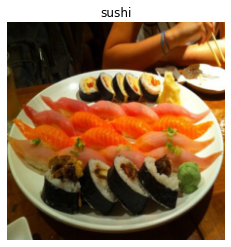

In [ ]:
# 1. View single image 
plt.imshow(image.permute(1,2,0)) 
plt.title(class_names[label]) 
plt.axis(False) 
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dim to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps 
image_out_of_conv_flattened = flatten(image_out_of_conv) 
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Our `image_out_of_conv_flattened` shape is very close to our desired output shape. The only difference is our current shape has a batch size and the dimensions are in a different order to the desired output

In [ ]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1) # change to [batch_size, N, P^2*C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape}")

Patch embedding sequence shape: torch.Size([1, 196, 768])


We have now matched the desired input and output shapes for the patch embedding layer of the ViT architecture using a couple of PyTorch layers

In [ ]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0]
single_flattened_feature_map.shape

torch.Size([1, 196])

In [ ]:
#single_flattened_feature_map.detach()

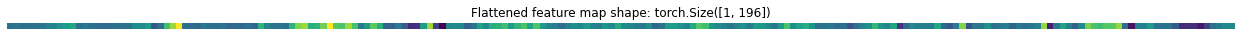

In [ ]:
# Get a single flattened feature map 
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0]

# Plot the flattened feature map visually 
plt.figure(figsize=(22,22)) 
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

We are essentially taking a 2D image and formatting it so it appears as a 1D sequence of text

In [ ]:
single_flattened_feature_map, single_flattened_feature_map.shape, single_flattened_feature_map.requires_grad

(tensor([[ 1.3712e-02,  3.9568e-02,  7.3173e-03,  3.3732e-03,  1.9861e-02,
           2.7892e-02,  8.9895e-02,  1.0528e-01,  1.6786e-01,  2.2051e-01,
           2.7171e-01,  1.7370e-03,  4.9030e-02,  7.0818e-03, -6.6329e-03,
           5.0690e-03, -1.3761e-02,  1.1716e-02,  1.3738e-02,  1.2729e-02,
           1.4620e-01,  1.4305e-01,  2.2224e-01, -8.7830e-02,  1.8609e-02,
           3.9825e-01,  5.6251e-01,  7.3707e-01,  1.1870e-02,  1.0318e-03,
          -2.6411e-02,  4.7596e-02,  8.9534e-03, -1.7587e-04,  2.6137e-02,
          -3.3840e-02, -1.1964e-02, -3.6598e-02,  1.0236e-02, -3.3974e-02,
           3.3521e-01,  1.1545e-01,  2.1623e-02,  3.5441e-02,  9.5761e-03,
           3.3317e-01,  5.2049e-01,  5.6837e-01,  3.1186e-01,  3.3753e-01,
           4.8898e-01,  7.3532e-01,  4.3587e-01,  4.0601e-01,  5.6831e-01,
           4.0085e-01,  5.0084e-02,  2.1657e-01,  4.4557e-01,  3.1556e-01,
          -3.4371e-02, -5.4560e-02,  6.2431e-02, -7.2253e-02, -2.6921e-01,
          -2.4634e-01,  2

### Turning the ViT patch embedding layer into a PyTorch module 

1. Create a class called `PatchEmbedding` which subclasses `nn.Module` (so it can be used a PyTorch layer).
2. Initialize the class with the parameters `in_channels=3`, `patch_size=16` (for ViT-Base) and `embedding_dim=768` (this is D for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using `nn.Conv2d()` (just like in 4.3 above).
4. Create a layer to flatten the patch feature maps into a single dimension (just like in 4.4 above).
5. Define a `forward()` method to take an input and pass it through the layers created in 3 and 4.
Make sure the output shape reflects the required output shape of the ViT architecture $$ (N×(P^2⋅C) $$


In [ ]:
# 1. Create a class which subclasses nn.Module 
class PatchEmbedding(nn.Module): 
  """
  Turns a 2D image into a 1D sequence learnable embedding vector

  Args:
    in_channels (int): Number of color channels for the input images. Defaults to 3 
    patch_size (int): Size of patches to convert input image into. Defaults to 16. 
    embedding_dim (int): Size of embedding to trun image into. Default to 768.
  """

  # 2. Initialize the class with appropiate variables 
  def __init__(self, 
               in_channels: int=3, 
               patch_size: int=16, 
               embedding_dim: int=768):
    super().__init__()

    # 3. Create a layer to turn an image into patches 
    self.patcher = nn.Conv2d(in_channels=in_channels, 
                             out_channels=embedding_dim, 
                             kernel_size=patch_size, 
                             stride=patch_size, 
                             padding=0)
    
    # 4. Create a layer to flatten the patch feature maps into a single dimension
    self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimension 
                              end_dim=3)
    
  # 5. Define the forward method 
  def forward(self, x):
    # Create assertion to check inputs are the correct shape 
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    # Perform the forward pass 
    x_patched = self.patcher(x) 
    x_flattened = self.flatten(x_patched) 
    # 6. Make sure the ouput shape has the right order 
    return x_flattened.permute(0,2,1) # adjust so the embedding is on the final dimension
    

In [ ]:
set_seeds() 

# Create an instance of patch embedding layer 
patchify = PatchEmbedding(in_channels=3, 
                          patch_size=16, 
                          embedding_dim=768)

# Pass a single image through 
print(f"Input image shape: {image.unsqueeze(0).shape}") 
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra dimension to represent batch_size of 1 (0th index)
print(f"Output patch embedding shape: {patch_embedded_image.shape}")


Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [ ]:
# Create random input sizes 
random_input_image = (1,3,224,224)
random_input_image_error = (1,3,250,250) # will error because size is incompatible

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(), 
        input_size=random_input_image, # try swapping this for "random_input_image_error" 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### Creating the class token embedding

Now we need to prepend a learnable embedding to the sequence of embedding patches

use `torch.cat()` on dim 1 (the `number_of_patches` dimensions 

In [ ]:
# View the patch embedding and the patch embedding shape
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.0564, -0.0080, -0.0478,  ...,  0.0420, -0.0197,  0.0138],
         [-0.0733,  0.0042, -0.0568,  ...,  0.0617, -0.0201,  0.0181],
         [-0.0529, -0.0026, -0.0459,  ...,  0.0181, -0.0267,  0.0319],
         ...,
         [-0.1800, -0.0069, -0.0385,  ...,  0.1066, -0.0684,  0.0270],
         [-0.3886, -0.0058, -0.0206,  ...,  0.1863, -0.1562,  0.0596],
         [-0.3880,  0.0265, -0.0642,  ...,  0.2279, -0.1801,  0.1684]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1] 

# Create the class token embedding as a learnable parameter that shares
# the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
# Show the first 10 examples of the class_token
print(class_token[:,:,:10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimensions")


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimensions


Just using `torch.ones()` for demonstration purposes. In reality, would likely create class token embedding with `torch.randn()` and improve the tokens over time

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dim

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0564, -0.0080, -0.0478,  ...,  0.0420, -0.0197,  0.0138],
         [-0.0733,  0.0042, -0.0568,  ...,  0.0617, -0.0201,  0.0181],
         ...,
         [-0.1800, -0.0069, -0.0385,  ...,  0.1066, -0.0684,  0.0270],
         [-0.3886, -0.0058, -0.0206,  ...,  0.1863, -0.1562,  0.0596],
         [-0.3880,  0.0265, -0.0642,  ...,  0.2279, -0.1801,  0.1684]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Creating the position embedding

- Add a learnable 1D set of position embeddings to [class_token, patch_embedding]
- Having this positional information would be important for the model to "understand" that the order of the patches matter

In [ ]:
# View the sequence of patch embeddings with prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0564, -0.0080, -0.0478,  ...,  0.0420, -0.0197,  0.0138],
          [-0.0733,  0.0042, -0.0568,  ...,  0.0617, -0.0201,  0.0181],
          ...,
          [-0.1800, -0.0069, -0.0385,  ...,  0.1066, -0.0684,  0.0270],
          [-0.3886, -0.0058, -0.0206,  ...,  0.1863, -0.1562,  0.0596],
          [-0.3880,  0.0265, -0.0642,  ...,  0.2279, -0.1801,  0.1684]]],
        grad_fn=<CatBackward0>), torch.Size([1, 197, 768]))

In [ ]:
# Calculate N (number of patches) 
number_of_patches = int((height*width) / patch_size**2) 

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the lernable 1D position embedding 
position_embedding = nn.Parameter(torch.ones(1, 
                                              number_of_patches+1, 
                                              embedding_dimension), 
                                   requires_grad=True) # ensure it's learnable

# Show the first 10 sequences and 10 position embedding values and check 
# the shape of the position embedding
print(position_embedding[:,:10,:10]) 
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# Add the position embedding to the patch and class token embedding 
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings shape: {patch_and_position_embedding.shape}" )

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9436, 0.9920, 0.9522,  ..., 1.0420, 0.9803, 1.0138],
         [0.9267, 1.0042, 0.9432,  ..., 1.0617, 0.9799, 1.0181],
         ...,
         [0.8200, 0.9931, 0.9615,  ..., 1.1066, 0.9316, 1.0270],
         [0.6114, 0.9942, 0.9794,  ..., 1.1863, 0.8438, 1.0596],
         [0.6120, 1.0265, 0.9358,  ..., 1.2279, 0.8199, 1.1684]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings shape: torch.Size([1, 197, 768])


### Putting it all together: from image to embedding

Steps
------
1. Setting the patch size 
2. Getting a single image, printing its shape and storing its height and width 
3. Adding a batch dimension to the single image so it's compatible with out `PatchEmbedding` layer 
4. Creating a `PatchEmbedding` layer with a `patch_size=16` and `embedding_dim=768`
5. Passing the single image through the `PatchEmbedding layer in 4 to create a sequence of patch embeddings
6. Creating a class token embedding like in section 4.6 
7. Prepending the class token embedding to the patch embeddings
8. Creating a position embedding
9. Adding the position embedding to the class token and patch embeddings created in step

In [ ]:
set_seeds() 

# 1. Set the patch size 
patch_size = 16 

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2] 

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dim shape: {x.shape}") 

# 4. Create patch embedding layer 
patch_embedding_layer = PatchEmbedding(in_channels=3, 
                                       patch_size=patch_size, 
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer 
patch_embedding = patch_embedding_layer(x) 
print(f"Patching embedding shape: {patch_embedding.shape}") 

# 6. Create class token embedding
batch_size = patch_embedding.shape[0] 
embedding_dimension = patch_embedding.shape[-1] 
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), 
                           requires_grad=True) 
print(f"Class token embedding shape: {class_token.shape}") 

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2) 
position_embedding = nn.Parameter(torch.ones(1,number_of_patches+1, embedding_dimension), 
                                  requires_grad=True)

# 9. Add position embedding to patch embedding with clas token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dim shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multi-Head Attention (MSA)

- MSA layer wrapped in a LayerNorm(LN) layer with a residual connection (the input to the layer gets added to the output of the layer)
- Layer Normalization helps improve training time and model generatlization (ability to aapt to unseen data) 

We can implement the MSA Lyaer in PyTorch with `torch.nn.MultiheadAttention()` with the parameters: 

- `embed_dim` - the embedding dimension (hidden size *D*)
- `num_heads` - how many attention heads to use
- `dropout` - whether or not to apply dropout to the attention layer
- `batch_first` - does our batch dimensino come first? 

In [ ]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
  """
  Creates a mutli-head self-attention block
  """
  # 2. Initialize the class with hyperparameters from Table 1
  def __init__(self, 
               embedding_dim: int=768, 
               num_heads: int=12, 
               attn_dropout: int=0):
    super().__init__()

    # 3. Create the Norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # 4. Create the Multi-Head Attention (MSA) layer 
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, 
                                                num_heads=num_heads, 
                                                dropout=attn_dropout, 
                                                batch_first=True)
    
  # 5. Create a forward() method to pas the data through the layers
  def forward(self, x):
    x = self.layer_norm(x) 
    attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                    key=x, # key embeddings 
                                    value=x, # value embeddings
                                    need_weights=False)
    return attn_output

In [ ]:
# Create an instance of MSABlock 
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, 
                                                             num_heads=12)

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## Equation 3: Mutlilayer Perceptron (MLP)

In [ ]:
# 1. Create a class that inherits from nn.Module 
class MLPBlock(nn.Module):
  """
  Creates a layer normalized multilayer perceptron block
  """
  # 2. Initialize the class with hyperparameters from ViT paper 
  def __init__(self, 
               embedding_dim: int=768, 
               mlp_size: int=3072, 
               dropout: int=0.1):
    super().__init__()

    # 3. Create the Norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # 4. Create the Multilayer perceptron (MLP) layer(s)
    self.mlp = nn.Sequential( 
        nn.Linear(in_features=embedding_dim, 
                  out_features=mlp_size), 
        nn.GELU(), 
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size, 
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  # 5. Create a forward() method to pass the data through the layers
  def forward(self, x): 
    x = self.layer_norm(x)
    x = self.mlp(x) 
    return x 



**Note:** our `MLPBlock()` doesn't include a skip or residual connection, we'll include this when we create the entire Transformer encoder later on. 

In [ ]:
# Create an instance of MLPBlock 
mlp_block = MLPBlock(embedding_dim=768, # from Table 1 
                     mlp_size=3072, # from Table 1 
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


The input and output shape of our data again stays the same when it goes in and out of the MLP block.

The shape does actually get changed when data gets passed through the `nn.Linear()` layers within the MLP block

## Create the Transformer Encoder

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).

Residual connections are achieved by addings a layer(s) input to its subsequent output. 

In the case of the ViT architecture, the residual connection means the input of the MSA block is added back to the output of the MSA block before it passes to the MLP block.

In the case of the ViT architecture, the residual connection means the input of the MSA block is added back to the output of the MSA block before it passes to the MLP block.

### Creating a Transformer Encoder by combining our custom made layers

1. Create a class called `TransformerEncoderBlock` that inherits from `torch.nn.Module` 
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model 
3. Instantiate the MSA block for equation 2 using our `MultiheadSelfAttentionBlock` from section 5.2 with the appropiate parameters
4. Instantiate a MLP block for equation 3 using our MLPBlock from section 6.2 with the appropiate parameters
5. Create a `forward()` method for our `TransformerEncoderBlock` class 
6. Create a residual connection for the MSA block (equation 2)
7. Create a residual connection for the MLP block (equation 3)

In [ ]:
# 1. Create a class that inherits from nn.Module 
class TransformerEncoderBlock(nn.Module):
  """
  Creates a Transformer Encoder block
  """ 
  # 2. Initialize the class with hyperparameters from Table 1 and Table 3 
  def __init__(self, 
               embedding_dim: int=768, # Hidden size D 
               num_heads: int=12, 
               mlp_size: int=3072,
               mlp_dropout: int=0, 
               attn_dropout: int=0):
    super().__init__()

    # 3. Create MSA block (equation 2)
    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, 
                                                 num_heads=num_heads, 
                                                 attn_dropout=attn_dropout)
    # 4. Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim, 
                              mlp_size=mlp_size, 
                              dropout=mlp_dropout)
    
  # 5. create a forward() method 
  def forward(self, x):

    # 6. Create a residual connection for MSA block (add the input to the output)
    x = self.msa_block(x) + x

    # 7. Create residual connection for MLP block (add the input to the output)
    x = self.mlp_block(x) + x

    return x

In [ ]:
# Create an instance of TransformerEncoderBlock 
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Creating a Transformer Encoder with PyTorch's Transformer layers


In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, 
                                                             nhead=12, 
                                                             dim_feedforward=3072, 
                                                             dropout=0.1, 
                                                             activation='gelu', 
                                                             batch_first=True, 
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Putting it all together to create ViT

In [ ]:
# 1. Create a ViT class that inherits from nn.Module 
class ViT(nn.Module): 
  """
  Creates a Vision Transformer architecture with ViT-Base hyperparameters by default. 
  """
  # 2. Initialize the class with hyperparameters from Table 1 and Table 3 
  def __init__(self, 
               img_size: int=224, 
               in_channels: int=3, 
               patch_size: int=16, 
               num_transformer_layers: int=12, 
               embedding_dim: int=768, 
               mlp_size: int=3072, 
               num_heads: int=12, 
               attn_dropout: int=0, # Dropout for attention projection
               mlp_dropout: int=0.1, # Dropout for patch and position embeddings
               embedding_dropout: int=0.1, 
               num_classes: int=1000):
    super().__init__()

    # 3. Make the iamge size divisable by the patch size 
    assert img_size % patch_size == 0, f"Image size must be divisable by patch_size"

    # 4. Calculate number of patches ((height * width)/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2 

    # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim), 
                                         requires_grad=True)
    
    # 6. Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), 
                                           requires_grad=True)
    
    # 7. Create embedding dropout value 
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # 8. Create patch embedding layer 
    self.patch_embedding = PatchEmbedding(in_channels=in_channels, 
                                          patch_size=patch_size, 
                                          embedding_dim=embedding_dim)
    
    # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim, 
                                                                       num_heads=num_heads, 
                                                                       mlp_size=mlp_size, 
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    

    # 10. Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim), 
        nn.Linear(in_features=embedding_dim, 
                  out_features=num_classes)
    )

  # 11. Create a forward() method 
  def forward(self, x): 

    # 12. Get batch size 
    batch_size = x.shape[0]

    # 13. Create class token embedding and expand it to match the batch size
    class_token = self.class_embedding.expand(batch_size, -1, -1)

    # 14. Create patch embedding
    x = self.patch_embedding(x) 

    # 15. Concat class embedding and patch embedding
    x = torch.cat((class_token, x), dim=1)

    # 16. Add position embedding to patch embedding 
    x = self.position_embedding + x

    # 17. Run embedding dropout 
    x = self.embedding_dropout(x) 

    # 18. Pass patch, position and class embedding through transformer encoder layers
    x = self.transformer_encoder(x) 

    # 19. Put 0 index logit through classifier
    x = self.classifier(x[:,0])

    return x


In [ ]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32 
class_token_embedding_single = nn.Parameter(data=torch.randn(1,1,768))
class__token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class__token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [ ]:
set_seeds()

# Create a random tensor with same shape as a single image 
random_image_tensor = torch.randn(1,3,224,224) 

# Create an instance of ViT with the number of classes we're working with 
vit = ViT(num_classes=len(class_names)) 

# Pass the random image tensor to our ViT instance
vit(random_image_tensor) 

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### Getting a visual summary of our ViT model 


In [ ]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
# summary(model=vit, 
#         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

## Setting up training code for our ViT model 

### Creating an optimizer 

Just using Adam with default beta1 and beta2, with weight decay of 0.1

### Creating a loss function 

Simple `torch.nn.CrossEntropyLoss()`

### Training our ViT model

In [ ]:
from going_modular import engine

# Set up the optimizer to optimize our ViT model parameters using hyperparameters from ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(), 
          
                             lr=1e-3, 
                             betas=[0.9, 0.999], 
                             weight_decay=0.1)

# Set up the loss functino for multi-class classification 
loss_fn = torch.nn.CrossEntropyLoss() 

# Set the seeds 
set_seeds() 

# Train the model and save the training results to a dictionary
results = engine.train(model=vit.to(device), 
                       train_dataloader=train_dataloader, 
                       test_dataloader=test_dataloader, 
                       optimizer=optimizer, 
                       loss_fn=loss_fn, 
                       epochs=10, 
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8769 | train_acc: 0.3008 | test_loss: 1.2143 | test_acc: 0.4422
Epoch: 2 | train_loss: 1.5405 | train_acc: 0.3008 | test_loss: 1.2356 | test_acc: 0.2576
Epoch: 3 | train_loss: 1.3484 | train_acc: 0.2734 | test_loss: 1.4053 | test_acc: 0.4223
Epoch: 4 | train_loss: 1.3977 | train_acc: 0.2617 | test_loss: 1.1364 | test_acc: 0.3598
Epoch: 5 | train_loss: 1.3192 | train_acc: 0.2852 | test_loss: 1.1237 | test_acc: 0.3400
Epoch: 6 | train_loss: 1.1498 | train_acc: 0.2500 | test_loss: 1.1654 | test_acc: 0.4223
Epoch: 7 | train_loss: 1.1552 | train_acc: 0.4414 | test_loss: 2.1056 | test_acc: 0.4025
Epoch: 8 | train_loss: 1.6226 | train_acc: 0.2734 | test_loss: 1.2457 | test_acc: 0.3201
Epoch: 9 | train_loss: 1.3798 | train_acc: 0.2773 | test_loss: 1.0823 | test_acc: 0.4621
Epoch: 10 | train_loss: 1.2745 | train_acc: 0.4531 | test_loss: 1.1385 | test_acc: 0.3598


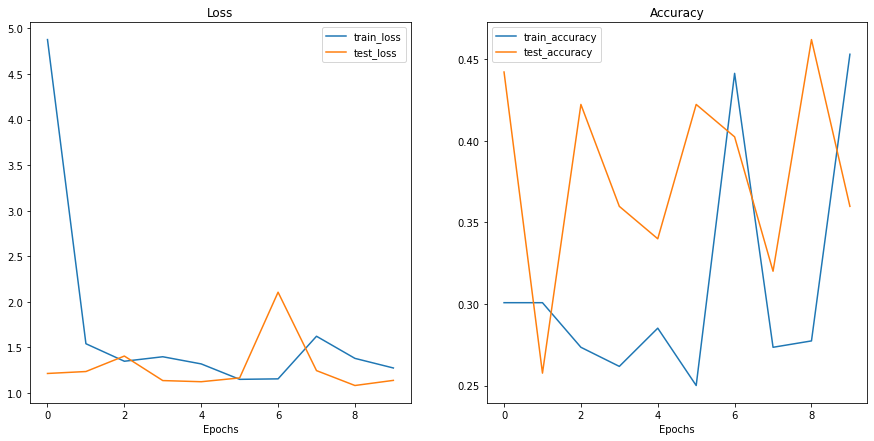

In [ ]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

## Using a pretrained ViT from torchvision.models on the same dataset

In [ ]:
# The following requires torch v0.12+ and torchvision v0.13+ 
import torch
import torchvision 
print(torch.__version__) 
print(torchvision.__version__)

1.13.0+cu116
0.14.0+cu116


In [ ]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# 1. Get pretrained weights for ViT-Base 
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Set up a ViT model instnce with pretrained weights 
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters 
for parameter in pretrained_vit.parameters(): 
  parameter.requires_grad = False 

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head) 
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

### Preparing data for the pretrained ViT model 

In [ ]:
# Get automatic transforms from pretrained ViT weights 
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders 
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders( 
    train_dir=train_dir, 
    test_dir=test_dir, 
    transform=pretrained_vit_transforms, 
    batch_size=32
)

### Train feature extractor ViT model

In [ ]:
from going_modular import engine 
# Create optimizer and loss function 
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit, 
                                      train_dataloader=train_dataloader_pretrained, 
                                      test_dataloader=test_dataloader_pretrained, 
                                      optimizer=optimizer, 
                                      loss_fn=loss_fn,
                                      epochs=10, 
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5210 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.3455 | train_acc: 0.9414 | test_loss: 0.2678 | test_acc: 0.9583
Epoch: 3 | train_loss: 0.2306 | train_acc: 0.9492 | test_loss: 0.2093 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.1543 | train_acc: 0.9648 | test_loss: 0.2278 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.1330 | train_acc: 0.9648 | test_loss: 0.1611 | test_acc: 0.9583
Epoch: 6 | train_loss: 0.1138 | train_acc: 0.9766 | test_loss: 0.1533 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.1478 | train_acc: 0.9766 | test_loss: 0.1635 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.0840 | train_acc: 0.9766 | test_loss: 0.1666 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.0838 | train_acc: 0.9805 | test_loss: 0.1548 | test_acc: 0.9375
Epoch: 10 | train_loss: 0.0691 | train_acc: 0.9883 | test_loss: 0.2208 | test_acc: 0.9176


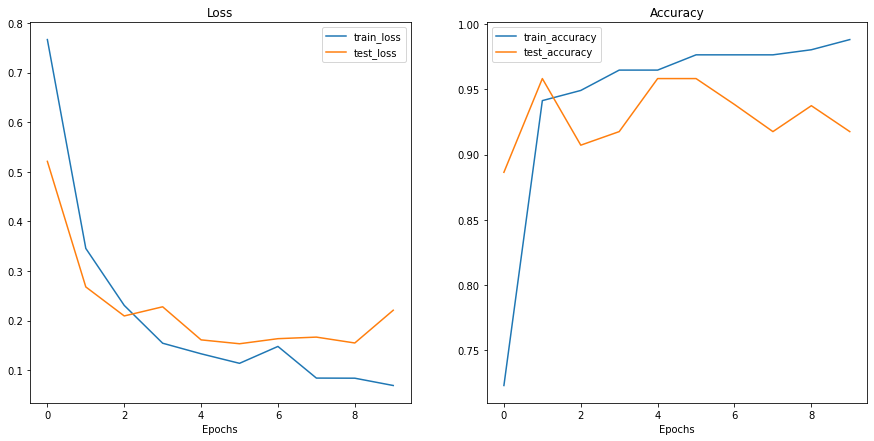

In [ ]:
# Plot the loss curves
plot_loss_curves(pretrained_vit_results)

In [ ]:
# Save the model
from going_modular import utils  

utils.save_model(model=pretrained_vit, 
                 target_dir='models', 
                 model_name='08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth')

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB
